In [3]:
import pandas as pd
import numpy as np

In [4]:
x_train = pd.read_csv('C:/Users/Nagore/PycharmProjects/MDLAB1/train.csv')
y_train = x_train['label'].copy()
x_train.drop('label', axis=1, inplace=True)

REDUCIR NUMERO DE INSTANCIAS Y DIMENSIONALIDAD

In [5]:
x_train_reducido=x_train.head(2000)
from sklearn.manifold import TSNE
x_train_reducido = TSNE(n_components=2,random_state=42).fit_transform(x_train_reducido)

PARAMETRO EKORKETA

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
i=2
bestSil=0
bestI=0
bestJ=0
while i<10:
    j=10
    while j<40:
        dbscan=DBSCAN(eps=i, min_samples=j)
        labels=dbscan.fit_predict(x_train_reducido)
        sample_cores=np.zeros_like(labels,dtype=bool)
        sample_cores[dbscan.core_sample_indices_]=True
        n_clusters=len(set(labels))- (1 if -1 in labels else 0)
        if(n_clusters==10):
            sil=silhouette_score(x_train_reducido,labels)
            if(sil>bestSil):
                bestSil=sil
                bestI=i
                bestJ=j
        j=j+1
    i=i+0.1
print("BEST EPSILON", bestI)
print("BEST MINPTS", bestJ)
print("BEST SLIHOUTTE",bestSil)

BEST EPSILON 4.200000000000001
BEST MINPTS 20
BEST SLIHOUTTE 0.31214648


In [8]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=4.2, min_samples=20)
labels=dbscan.fit_predict(x_train_reducido)
print(labels)

[0 1 0 ... 3 7 5]


In [9]:
kont = np.sum(labels== -1)
print("Clasificadas como ruido: ",kont)
print("Clasificadas como cluster: ",np.sum(labels!=-1))

Clasificadas como ruido:  126
Clasificadas como cluster:  1874


In [10]:
sample_cores=np.zeros_like(labels,dtype=bool)
sample_cores[dbscan.core_sample_indices_]=True
n_clusters=len(set(labels))- (1 if -1 in labels else 0)
print('Numero de clusters:',n_clusters)

Numero de clusters: 10


In [13]:
conteo_de_valores = {}

for label in labels:
    if label !=-1:
        if label in conteo_de_valores:
            conteo_de_valores[label] += 1
        else:
            conteo_de_valores[label] = 1

for label, count in conteo_de_valores.items():
    print(f"Cluster {label}: {count} instancias")

Cluster 0: 249 instancias
Cluster 1: 191 instancias
Cluster 5: 478 instancias
Cluster 2: 99 instancias
Cluster 3: 59 instancias
Cluster 7: 192 instancias
Cluster 4: 139 instancias
Cluster 6: 190 instancias
Cluster 8: 205 instancias
Cluster 9: 72 instancias


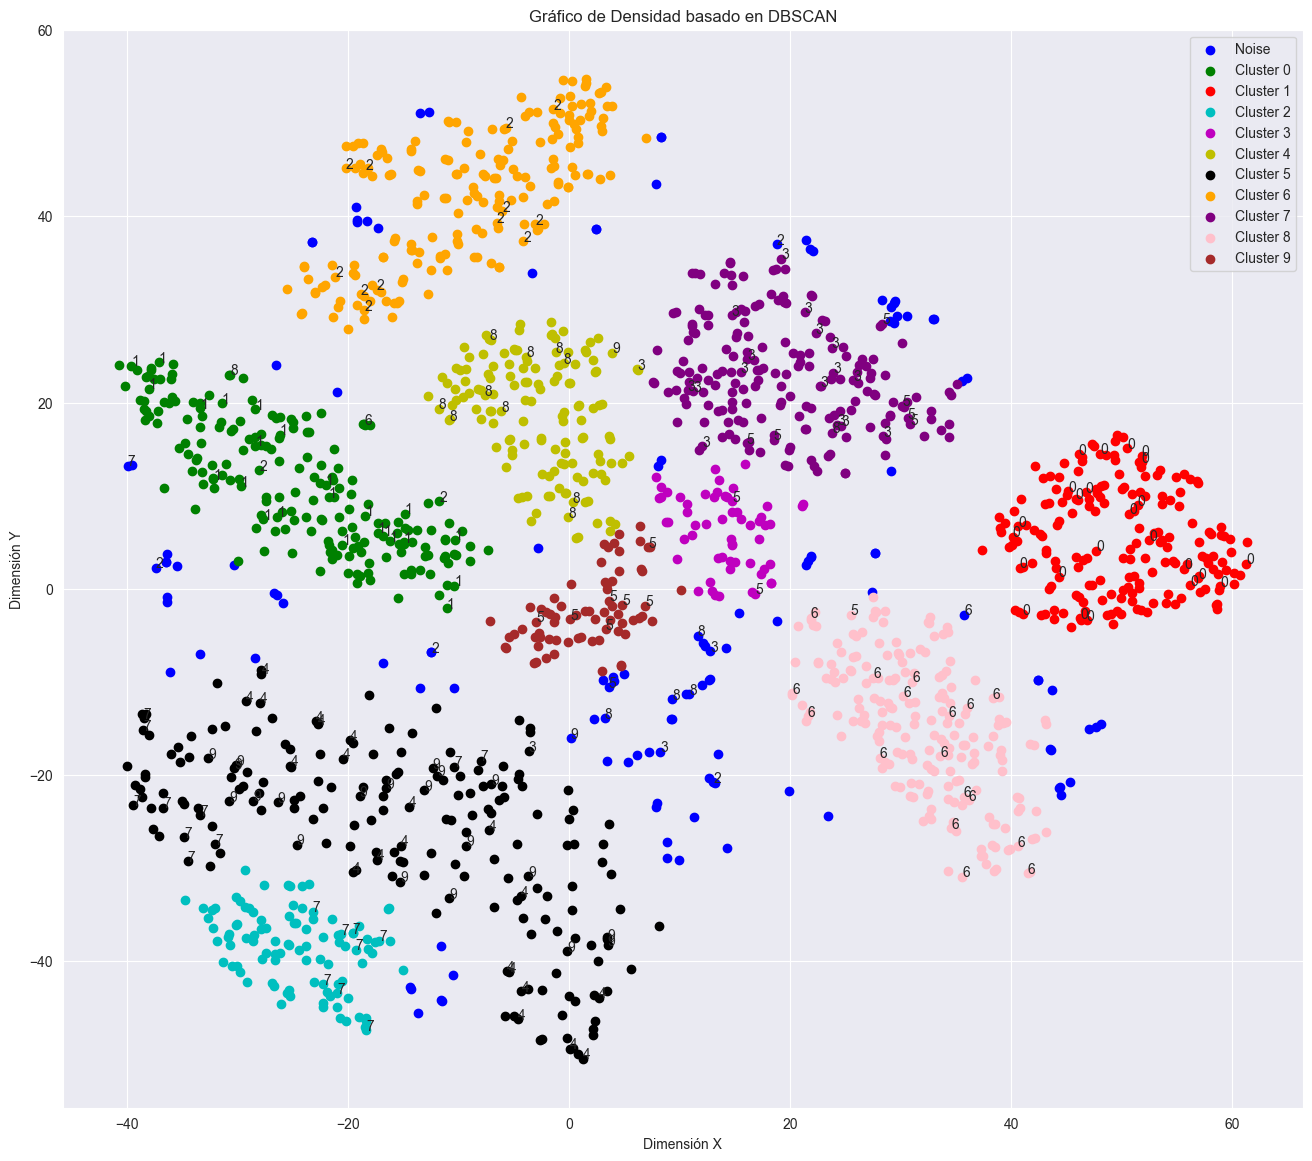

In [14]:
import matplotlib.pyplot as plt
unique_labels = set(labels) - {-1}
samples = 200
colores = ['g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'brown', 'teal', 'lime', 'navy', 'gray']
plt.figure(figsize=(16, 14))
noise_points = np.array([x_train_reducido[i] for i in range(len(x_train_reducido)) if labels[i] == -1])
plt.scatter(noise_points[:samples, 0], noise_points[:samples, 1], c='blue', label='Noise')

for label in unique_labels:
    cluster_points = np.array([x_train_reducido[i] for i in range(len(x_train_reducido)) if labels[i] == label])
    plt.scatter(cluster_points[:samples, 0], cluster_points[:samples, 1], c=colores[label % len(colores)], label=f'Cluster {label}')
for i in range(samples):
    plt.text(x_train_reducido[i,0],x_train_reducido[i,1], y_train[i])

plt.title('Gráfico de Densidad basado en DBSCAN')
plt.xlabel('Dimensión X')
plt.ylabel('Dimensión Y')
plt.legend()
plt.show()

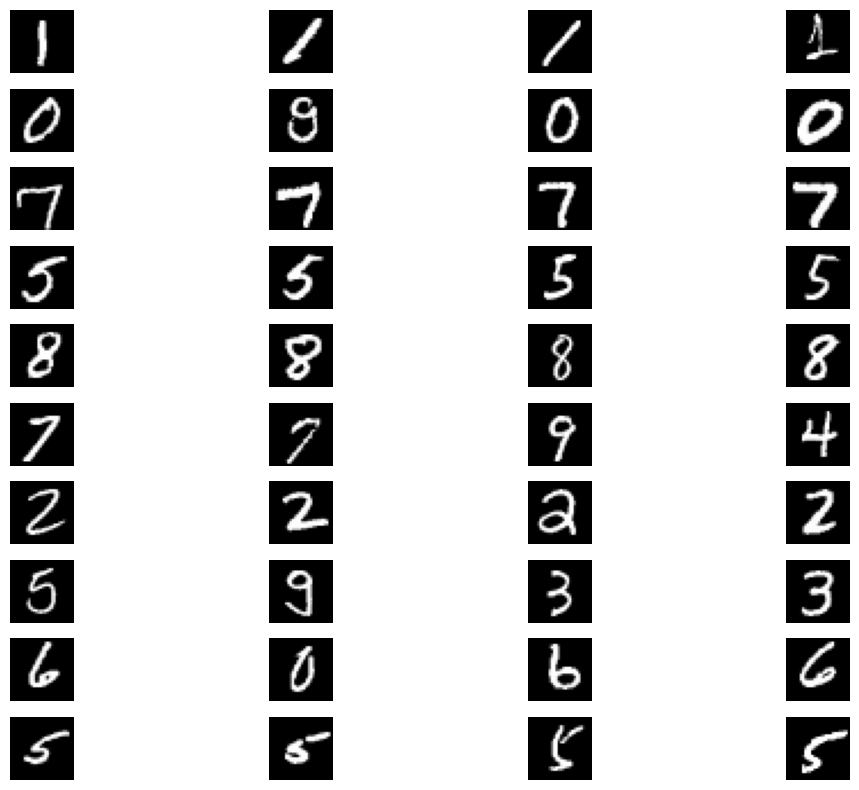

In [15]:
clusters = {cluster_id: [] for cluster_id in range(n_clusters)}

for image_index, cluster_label in enumerate(labels):
    if(cluster_label!=-1):
        clusters[cluster_label].append(x_train.iloc[image_index])

n_images=4
plt.figure(figsize=(12, 8))

for cluster_id in range(n_clusters):
    cluster_images = clusters[cluster_id]
    if len(cluster_images) < n_images:
        continue
    random_indices = np.random.choice(len(cluster_images), n_images, replace=False)
    for i, random_index in enumerate(random_indices):
        image_data = cluster_images[random_index].values.reshape((28, 28))
        plt.subplot(n_clusters, n_images, cluster_id * n_images + i + 1)
        plt.imshow(image_data, cmap='gray')  # Suponiendo imágenes en escala de grises
        plt.axis('off')

plt.tight_layout()
plt.show()

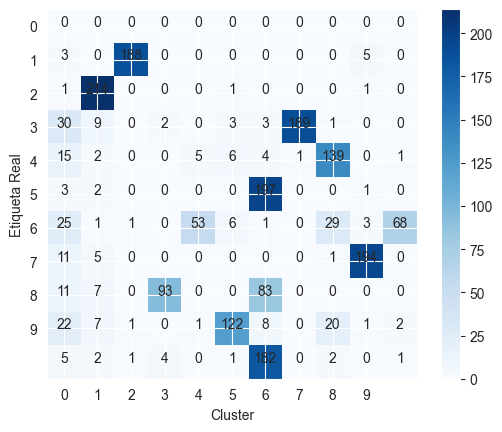

In [16]:
from sklearn.metrics import confusion_matrix

# El atributo generado por K-means es int, hay que pasarlos a string
to_string = lambda x : str(x)
y_train=y_train.head(2000)
# Obtener matriz de confusión Class to clustering eval
cm = confusion_matrix( np.vectorize(to_string)(y_train),np.vectorize(to_string)(labels))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

tick_marks = np.arange(len(np.unique(y_train)))
plt.xticks(tick_marks, np.unique(y_train))
plt.yticks(tick_marks, np.unique(y_train))

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),horizontalalignment="center")

plt.ylabel('Etiqueta Real')
plt.xlabel('Cluster')
plt.show()

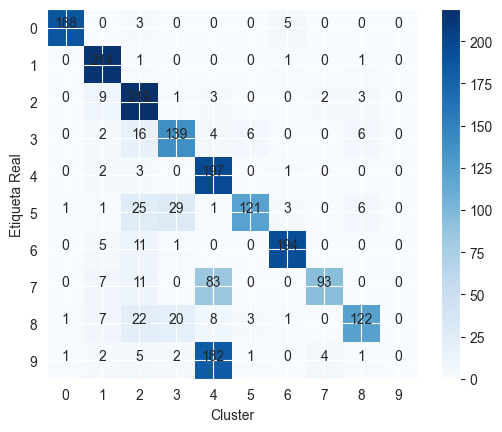

Porcentaje de error: 25.65%


In [17]:
from sklearn.metrics import accuracy_score

def remap_labels(original_labels, cluster_labels):
    mapping = {}
    for cluster_label in np.unique(cluster_labels):
        original_label = np.argmax(np.bincount(original_labels[cluster_labels == cluster_label]))
        #print(original_label)
        mapping[cluster_label] = original_label
    remapped_labels = np.vectorize(mapping.get)(cluster_labels)
    return remapped_labels


remapped_labels = remap_labels(y_train, labels)
cm = confusion_matrix(y_train, remapped_labels)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

tick_marks = np.arange(len(np.unique(y_train)))
plt.xticks(tick_marks, np.unique(y_train))
plt.yticks(tick_marks, np.unique(y_train))

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),horizontalalignment="center")

plt.ylabel('Etiqueta Real')
plt.xlabel('Cluster')
plt.show()

# Calcula el porcentaje de error
accuracy = accuracy_score(y_train, remapped_labels)
error_rate = 1 - accuracy
print(f'Porcentaje de error: {error_rate * 100:.2f}%')
